---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

### Saverio Monaco
##### MAT: 2012264

# Homework 2 - Unsupervised Deep Learning
---
---

### Dataset

In [304]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import pandas as pd

# Deep Learning stuff
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Images display and plots
import matplotlib.pyplot as plt
import plotly.express as px

# Other
import os
from tqdm import tqdm # this module is useful to plot progress bars

# Automatic tuning tool
import optuna


In [3]:
# Setting the values of the seeds for reproducibility
torch.manual_seed(2012264)    
np.random.seed(2012264)


In [4]:
# Transformation for data augmentation
augmentation = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.RandomVerticalFlip(p=0.5),
                     transforms.RandomCrop(28,padding=2)])

# If we have already the datafolder, do not download.
if(os.path.isdir('./classifier_data/FashionMNIST')):
    train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
    test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=False,
                                                     transform = transforms.Compose([transforms.ToTensor()]) ) 
                                                      
else:
    train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
    test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
    

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [5]:
train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle=True, num_workers=0)


In [6]:
# Check for the ranges of value of the images
# There are two standards of representing grayscale images:
#  1. Each pixel ranges from 0 to 1
#  2. Each pixel ranges from 0 to 255

# The second one present more numerical instability

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in train_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min
        
print('TRAINING DATASET')
print(' range:', absmin.item(), '-', absmax.item())

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in test_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min

print('\nTEST DATASET')
print(' range:', absmin.item(), '-', absmax.item())

TRAINING DATASET
 range: 0.0 - 1.0

TEST DATASET
 range: 0.0 - 1.0


In [7]:
print('Number of instances in training dataset:', np.shape(train_dataset.data)[0])
print('Number of instances in testing dataset: ', np.shape(test_dataset.data)[0])

print('\nSize of the images:', np.shape(train_dataset.data[0].numpy()))

Number of instances in training dataset: 60000
Number of instances in testing dataset:  10000

Size of the images: (28, 28)


In [8]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


In [9]:
def plot_mnistimg(dataset, sample, output = False, size = 3):
    '''
    Display the sample-th image from dataset (can be trainingset or testset) and its true
    label.
    Eventually display the predicted label in output.
    Size of the image can be changed changing size input parameter
    '''
    
    # Convert output (int) through the description of the images (str)
    description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
    
    image = np.array(dataset[sample][0])[0] # Image to display
    label = dataset[sample][1]              # Relative label (int)

    fig = plt.figure(figsize=(size,size))
    plt.imshow(image, cmap='Greys')
    
    print(f"Sample: {sample}")
    print(f"True Label: {description[label]}")
    
    if output:
        print(f"Prediction: {description[output]}")
    
    plt.axis("off")
    plt.show()
    

Sample: 10
True Label: T-shirt/top


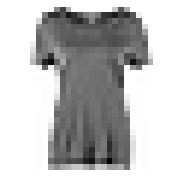

In [10]:
plot_mnistimg(train_dataset, 10)


### Autoencoder class

In [310]:
class autoencoder(nn.Module):
    '''
    Initialization: encoded_space_dim is the dimension of the encoded space 'bottleneck part'
                    Images will be 'compressed' to a vector of dimension encoded_space_dim
    '''
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.encoded_space_dim = encoded_space_dim
        
        ###############
        #   ENCODER   #
        ###############
        
        ### Convolutional section
        self.encoder_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.encoder_flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*32, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        
        ###############
        #   DECODER   #
        ###############
        
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.decoder_unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward_encoder(self, x):
        '''
        Encode part of forward
        x: Image to encode (as Tensor)
        '''
        # Apply convolutions
        x = self.encoder_conv(x)
        # Flatten
        x = self.encoder_flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def forward_decoder(self, x):
        '''
        Decode part of forward
        x: Encoded image [Tensor] of size encoded_space_dim
        '''
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.decoder_unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
    
    def forward(self,x):
        '''
        Encode and Decode
        x: Image to autoencode (as Tensor)
        '''
        x = self.forward_encoder(x)
        x = self.forward_decoder(x)
        
        return(x)
    
    def train_epoch(self, device, dataloader, loss_fn, optimizer, verbose = False):
        '''
        Train the network for a single step
        '''
        self.train() # Set train mode
        
        # Iterate the dataloader
        for image_batch, _ in dataloader: # with "_" we just ignore labels 'unsupervised deep learning'
            # Move tensor to device
            image_batch = image_batch.to(device)
            
            # Encode and Decode data: this is our reconstructed image
            autoencoded_data = self(image_batch)
            
            # Compute the loss between the real and reconstructed images
            loss = loss_fn(autoencoded_data, image_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                # Print batch loss
                print('\t partial train loss (single batch): %f' % (loss.data))
                
    def test_epoch(self, device, dataloader, loss_fn):
        '''
        Test epoch during a step
        '''
        self.eval() # Evaluation mode
        
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out   = []
            conc_label = []
            
            for image_batch, _ in dataloader:
                # Move tensor to device
                image_batch = image_batch.to(device)
                
                # Encode and Decode data: this is our reconstructed image
                autoencoded_data = self(image_batch)
                
                # Append the network output to the lists
                conc_out.append(autoencoded_data.cpu())
                # Append the true image to the lists
                conc_label.append(image_batch.cpu())
            
            # Create a single tensor with all the values in the lists
            conc_out   = torch.cat(conc_out)
            conc_label = torch.cat(conc_label)
            
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
            
        return val_loss.data
    
    def trainmodel(self, epochs, device, trainloader, testloader, loss_fn, optimizer, progress = False, plotloss = False):
        '''
        Main function to train the model, it iterates epochs-times self.train_epoch
        progress = True: shows the real image and the output of an image at each iteration
        plotloss = True: plots the loss on the test set
        '''
        
        # Saves the error on the test set on an array. if plotloss is True it plots the 
        # learning curve
        val_losses   = []
        
        for epoch in range(epochs):
            print('EPOCH %d/%d' % (epoch + 1, epochs))
            
            # TRAINING
            self.train_epoch(device, trainloader, loss_fn, optimizer)
            
            # TESTING
            val_loss = self.test_epoch(device, testloader, loss_fn)
            val_losses.append(val_loss)
            
            print('\t VALIDATION - EPOCH %d/%d - loss: %f\n' % (epoch + 1, epochs, val_loss))
            
            if progress:
                ### Plot progress
                # Get the output of a specific image (the test image at index 0 in this case)
                img = test_dataset[0][0].unsqueeze(0).to(device)
                self.eval()
                with torch.no_grad():
                    rec_img  = self(img)
                # Plot the reconstructed image
                fig, axs = plt.subplots(1, 2, figsize=(4,2))
                axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
                axs[0].set_title('Original')
                axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
                axs[1].set_title('Recon (EPOCH %d)' % (epoch + 1))
                axs[0].axis('off')
                axs[1].axis('off')
                plt.tight_layout()
                plt.pause(0.1)
                # Save figures
                plt.show()
                plt.close()
                
        if plotloss:
            plt.plot(np.arange(len(val_losses)), val_losses, 'o-', label='Test error')
            plt.legend()
            plt.show()
            plt.close()
            
    def save(self, file=False):
        '''
        Just save the model in ./models folder.
        if file = False it overwrites ./models/autoencoder.pth. else it saves it on the name specified
        '''
        if file:
            torch.save(self.state_dict(), './models/'+str(file))
        else:
            torch.save(self.state_dict(), './models/autoencoder.pth')
            
    def plot_encodedspace(self):
        '''
        Plot the points of the testset in the encoded space, with a color relative to their label
        ONLY IF encoded_space_dim IS 2 OR 3
        '''
        label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
                     'sneaker','bag','boot']
        if self.encoded_space_dim == 2:
            ### Get the encoded representation of the test samples
            encoded_samples = []
            for sample in tqdm(test_dataset):
                img = sample[0].unsqueeze(0).to(device)
                label = sample[1]
                # Encode image
                self.eval()
                with torch.no_grad():
                    encoded_img  = self.forward_encoder(img)
                # Append to list
                encoded_img = encoded_img.flatten().cpu().numpy()
                encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
                encoded_sample['label'] = label
                encoded_samples.append(encoded_sample)
                
            # Convert to a dataframe
            encoded_samples = pd.DataFrame(encoded_samples)
            
            fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
                             color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
            fig.show()
            
        if self.encoded_space_dim == 3:
            ### Get the encoded representation of the test samples
            encoded_samples = []
            for sample in tqdm(test_dataset):
                img = sample[0].unsqueeze(0).to(device)
                label = sample[1]
                # Encode image
                self.eval()
                with torch.no_grad():
                    encoded_img  = self.forward_encoder(img)
                # Append to list
                encoded_img = encoded_img.flatten().cpu().numpy()
                encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
                encoded_sample['label'] = label
                encoded_samples.append(encoded_sample)
                
            # Convert to a dataframe
            encoded_samples = pd.DataFrame(encoded_samples)
            fig = px.scatter_3d(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                                color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
            
            fig.update_traces(marker={'size': 1.5})
            fig.show()
            

In [274]:
model = autoencoder(2)
model

autoencoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d

In [294]:
load = True


In [229]:
if not load:
    params_to_optimize = [{'params' : model.parameters()}]
    model.trainmodel(10, device, train_dataloader, test_dataloader, torch.nn.MSELoss(), 
                   torch.optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-5), progress = True , plotloss = True)
    model.save()

else:
    model.load_state_dict(torch.load('./models/autoencoder.pth'))
    

100%|██████████| 10000/10000 [00:08<00:00, 1157.57it/s]


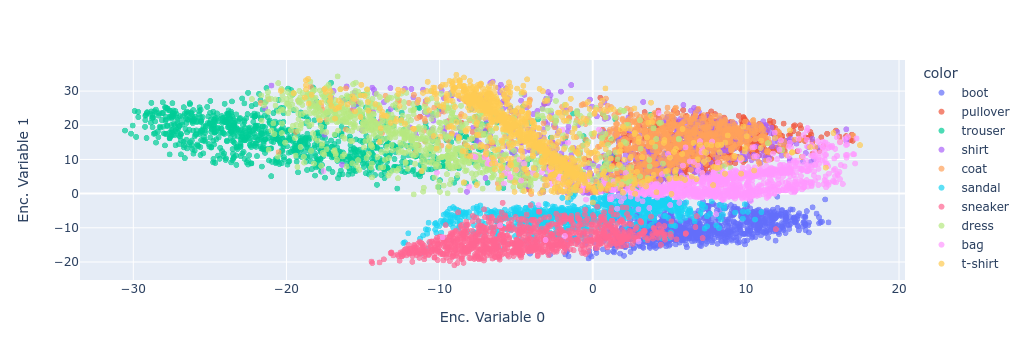

In [230]:
model.plot_encodedspace()


100%|██████████| 10000/10000 [00:09<00:00, 1041.57it/s]


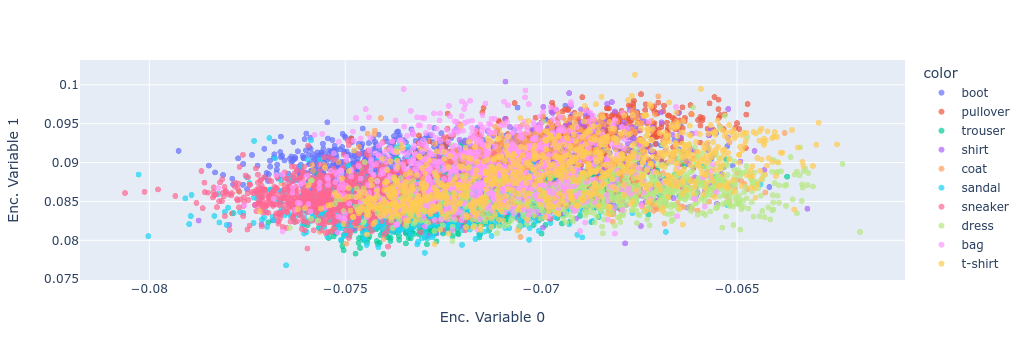

In [231]:
untrained_model = autoencoder(2)
untrained_model.plot_encodedspace()


### Sneaker to Sandal

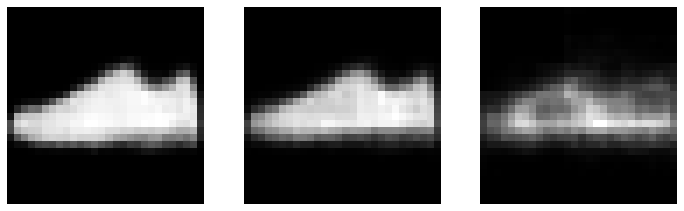

In [258]:
enc_x = -7
enc_ys = np.linspace(-20,-5,3)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
for i, enc_y in enumerate(enc_ys):
    axs[i].imshow(model.forward_decoder( torch.Tensor([[enc_x,enc_y]]) ).detach().cpu().squeeze().numpy() , cmap='gist_gray')
    axs[i].axis('off')

Using Plotly, it is possible to visualize a 3D Encoded Space

100%|██████████| 10000/10000 [00:10<00:00, 924.80it/s]


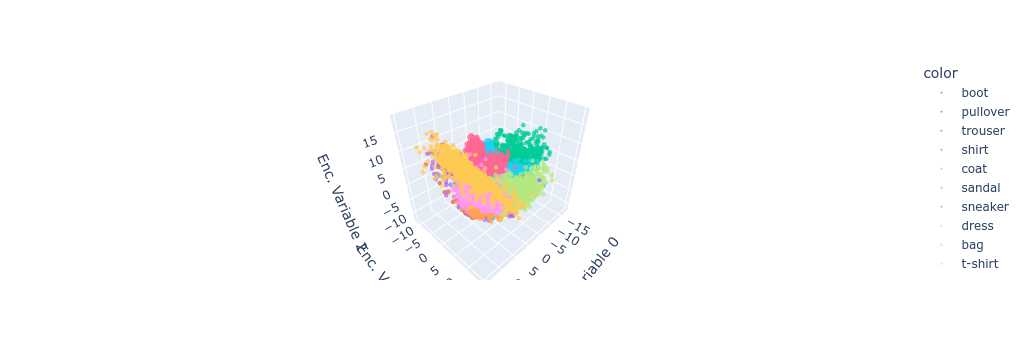

In [301]:
model3d = autoencoder(3)
if not load:
    params_to_optimize = [{'params' : model3d.parameters()}]
    model3d.trainmodel(10, device, train_dataloader, test_dataloader, torch.nn.MSELoss(), 
                   torch.optim.Adam(params_to_optimize, lr=1e-2, weight_decay=1e-5), progress = True , plotloss = True)
    model3d.save('autoencoder3d.pth')

else:
    model3d.load_state_dict(torch.load('./models/autoencoder3d.pth'))
    
model3d.plot_encodedspace()


In [355]:
def optuna_find_hparameters():
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
    
    def optuna_train(trial):
        epochs = 3
        optimizers = [torch.optim.Adam, torch.optim.SGD]
        cfg = {
          'dimend': trial.suggest_categorical('dimend',[1,2,3,4,5]),
          'lr' : trial.suggest_loguniform('lr', 1e-3, 1e-2),
          'optimizer': trial.suggest_categorical('optimizer',list(range(len(optimizers))))}
        
        
        optmodel =  autoencoder(cfg['dimend'])
        for epoch in range(epochs):
            
            # TRAINING
            optmodel.train_epoch(device, train_dataloader, torch.nn.MSELoss(), optimizers[cfg['optimizer']](optmodel.parameters(), lr=cfg['lr']))
            
            # TESTING
            val_loss = optmodel.test_epoch(device, test_dataloader, torch.nn.MSELoss())
            
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        return val_loss
    
    study.optimize(optuna_train, n_trials=20)

In [356]:
optuna_find_hparameters()

[I 2022-01-19 23:24:55,386] A new study created in memory with name: no-name-5edf5f28-59d3-4fef-95a4-f78d6889c0f8
[I 2022-01-19 23:25:49,961] Trial 0 finished with value: 0.12901215255260468 and parameters: {'dimend': 2, 'lr': 0.0063238805200077595, 'optimizer': 1}. Best is trial 0 with value: 0.12901215255260468.
[I 2022-01-19 23:26:44,278] Trial 1 finished with value: 0.1287471354007721 and parameters: {'dimend': 2, 'lr': 0.005210339218108149, 'optimizer': 1}. Best is trial 1 with value: 0.1287471354007721.
[I 2022-01-19 23:27:38,558] Trial 2 finished with value: 0.14297525584697723 and parameters: {'dimend': 2, 'lr': 0.0030264476873594777, 'optimizer': 1}. Best is trial 1 with value: 0.1287471354007721.
[I 2022-01-19 23:28:32,754] Trial 3 finished with value: 0.13713520765304565 and parameters: {'dimend': 4, 'lr': 0.001524074143405582, 'optimizer': 1}. Best is trial 1 with value: 0.1287471354007721.
[I 2022-01-19 23:29:28,533] Trial 4 finished with value: 0.1256466954946518 and para

KeyboardInterrupt: 